# Exploration, Cleaning and Preparation Process

## Import

In [1]:
#Packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
#Files
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

## Functions

Spoiler: The main features this dataset will be dicovering are passenger class and sex. Therefore we need to calculate whether each of the other (engineered) is independent from both of these.  

In [3]:
#This function should give us an idea how much a given ordinal feature is independent from a given "main" feature
#It returns a "measurement" for each of the categories:
#     - value close to zero mean that the new feature can be explained by the feature already looked at
#     - negative values: feature leads to a higher survival rate AND is not explained by another feature
#     - threshold for this notebook is 25 % not explained surviaval rate


def ind_cat_pclass(feature, new_df, dataframe):
    #Inputs are a categorical feature and df_train adjusted for NaNs 
    s = str(feature)
    #Dictionary for comparisons:
    comparisons = {}
    
    #Vector which shows the avarage survival(Index = 1) rate per class
    pc_surv_crosstab = pd.crosstab(dataframe["Survived"], dataframe["Pclass"], normalize = "columns")
    pc_surv_vector = np.matrix(pc_surv_crosstab.loc[1,:])
    
    
    #relative frequency in classes
    cross_tab = pd.crosstab(new_df[s], new_df.Pclass, normalize = "index")

    #actual survival rates
    surv_crosstab = pd.crosstab(new_df[s], new_df["Survived"], normalize = "index")
    
    for e in new_df[s].unique():
        #for comparison
        pc_vector = np.matrix(cross_tab.loc[e ,:]).transpose()
        deviation = float((pc_surv_vector * pc_vector)/surv_crosstab.loc[e, 1] - 1)
        comparisons.update({e : deviation})
    
    #after execution
    return comparisons
    

In [4]:
def ind_cat_sex(feature, new_df, dataframe):
    #Inputs are a categorical feature and df_train adjusted for NaNs 
    s = str(feature)
    #Dictionary for comparisons:
    comparisons = {}
    
    #Vector which shows the avarage survival(Index = 1) rate per class
    sex_surv_crosstab = pd.crosstab(dataframe["Survived"], dataframe["Sex"], normalize = "columns")
    sex_surv_vector = np.matrix(sex_surv_crosstab.loc[1,:])
    
    #relative frequency in sexes
    cross_tab = pd.crosstab(new_df[s], new_df.Sex, normalize = "index")

    #actual survival rates
    surv_crosstab = pd.crosstab(new_df[s], new_df["Survived"], normalize = "index")
    
    for e in new_df[s].unique():
        #for comparison
        sex_vector = np.matrix(cross_tab.loc[e ,:]).transpose()
        deviation = float((sex_surv_vector * sex_vector)/surv_crosstab.loc[e, 1] - 1)
        comparisons.update({e : deviation})
    
    #after execution
    return comparisons

In [5]:
#Selecting a dataframe by a column's non-NaN values
def sel_non_nan(feature, dataframe):
    s = str(feature)
    #selection without NaNs:
    selection = dataframe[dataframe[s].isnull() == False].index.tolist()
    new_df = pd.DataFrame(dataframe.loc[selection,:])
    return new_df

In [6]:
#Creating new binary columns for each category in a given column (NaNs will be counted and need to be transformed to 0 later)
def binarization(feature, df_woNaN, dataframe):
    s = str(feature)
    for e in df_woNaN[s].unique():
        new_feature = str(e)
        dataframe[new_feature] = df_woNaN[s] == e
        dataframe[new_feature].replace([False, True],[0,1], inplace= True)

In [7]:
#Finding NaN values in all columns with a little function
def count_nan(dataframe):
    for col in dataframe.columns:
        nans = len(dataframe[col])-dataframe[col].count()
        print("There are " + str(nans) + " missing values in " + col)

## Training Set Exploration

In [8]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
len(df_train)

891

In [10]:
df_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

The differen columns look good so far. Different scales might require conversion to a format that is interpretable by ML models.

In [11]:
#Finding NaN values
count_nan(df_train)

There are 0 missing values in PassengerId
There are 0 missing values in Survived
There are 0 missing values in Pclass
There are 0 missing values in Name
There are 0 missing values in Sex
There are 177 missing values in Age
There are 0 missing values in SibSp
There are 0 missing values in Parch
There are 0 missing values in Ticket
There are 0 missing values in Fare
There are 687 missing values in Cabin
There are 2 missing values in Embarked


"Age" unfortunately has a problematicly high number of missing values (177/891 ~= 20%). Cabin could be already dropped due to a huge likelyhood of insignificance but an exploration could make it more obvious.

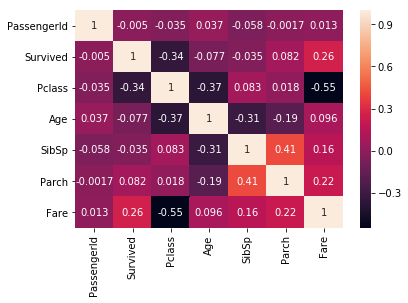

In [12]:
#Correlation between numeric features of the dataframe
sns.heatmap( df_train.corr(), annot = True )
plt.show()

First of all this heatmap shows us that there is a low but existing correlation between the the target "Survived" and two features "Pclass" and "Fare" respectively. Other numeric features could be assed later can be excluded from the analysis.

The second thing that becomes visible is that "Fare" and "Pclass" are neatively correlated. This means that passengers in a higher class had to pay more for their ticket, which is expectable. For our analysis it is essential to have mostly independant features. Because of that we have to decide which feature might be better for our further analysis.

## Preprocessing (numeric features)

### Passenger Class

Pclass          1         2         3       All
Survived                                       
0         0.37037  0.527174  0.757637  0.616162
1         0.62963  0.472826  0.242363  0.383838


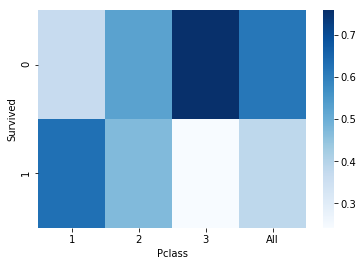

In [13]:
crossSPc = pd.crosstab(df_train["Survived"], df_train["Pclass"], margins= True, normalize = "columns")

print(crossSPc)

#Heatmap
sns.heatmap(crossSPc, cmap = "Blues")
plt.show()

In [14]:
binarization("Pclass", df_train, df_train)
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,3,1,2
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,0,0


### Fare

Unfortunately fare is not very informative, as it is more continious than "Pclass" but offers less of an explanation for survival (measured in correlation).

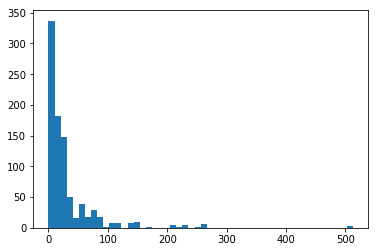

In [15]:
plt.hist(df_train["Fare"], bins = 50)
plt.show()

Turning "Fare" into a categorical feature

In [16]:
fare_list= []
for e in df_train["Fare"]:
    if e <= 10:
        fare_list.append("u10")
    elif 10 < e <= 20:
        fare_list.append("b1020")
    elif 20 < e <= 30:
        fare_list.append("b2030")
    elif 30 < e <= 40:
        fare_list.append("b3040")
    elif 40 < e <= 60:
        fare_list.append("b4060")
    elif 60 < e <= 80:
        fare_list.append("b6080")
    elif 80 < e <= 100:
        fare_list.append("b80100")
    elif 100 < e <= 200:
        fare_list.append("b100200")
    elif 200 < e <= 300:
        fare_list.append("b200300")
    else:
        fare_list.append("g300")
        
df_train["cat_fare"] = fare_list

In [17]:
df_train["cat_fare"].value_counts()

u10        336
b1020      179
b2030      142
b3040       58
b4060       54
b6080       48
b100200     33
b80100      21
b200300     17
g300         3
Name: cat_fare, dtype: int64

Frequencies:

In [18]:
surv_rate_fare = {}

for e in df_train["cat_fare"].unique():
    selection = df_train.loc[df_train["cat_fare"] == e, :]
    freq = sum(selection["Survived"])/len(selection["Survived"])
    surv_rate_fare.update({e : freq})

surv_rate_fare

{'u10': 0.19940476190476192,
 'b6080': 0.5208333333333334,
 'b4060': 0.5740740740740741,
 'b2030': 0.44366197183098594,
 'b1020': 0.4245810055865922,
 'b3040': 0.39655172413793105,
 'b200300': 0.6470588235294118,
 'b100200': 0.7575757575757576,
 'b80100': 0.8571428571428571,
 'g300': 1.0}

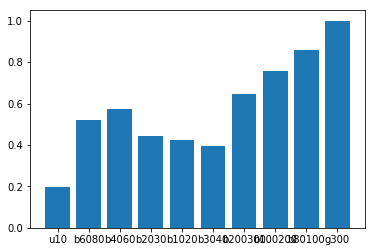

In [19]:
plt.bar(range(len(surv_rate_fare)), list(surv_rate_fare.values()), align='center')
plt.xticks(range(len(surv_rate_fare)), list(surv_rate_fare.keys()))
plt.show()

Comparing now the actual survivalrate with the survivalrate explained by the Pclass

In [20]:
ind_cat_pclass("cat_fare", df_train, df_train)

{'u10': 0.27074914250730453,
 'b6080': 0.05654910777243205,
 'b4060': -0.0808026768466864,
 'b2030': 0.003164910000019283,
 'b1020': -0.13199577521240458,
 'b3040': 0.13872433623895675,
 'b200300': -0.026936026936026924,
 'b100200': -0.16888888888888887,
 'b80100': -0.26543209876543206,
 'g300': -0.37037037037037035}

In [21]:
ind_cat_sex("cat_fare", df_train, df_train)

{'u10': 0.47572330534019214,
 'b6080': -0.10629149234454527,
 'b4060': -0.29623318219580175,
 'b2030': -0.05619633555144499,
 'b1020': 0.012614520991569123,
 'b3040': -0.042640266814235606,
 'b200300': -0.15492097675916905,
 'b100200': -0.2638867853712925,
 'b80100': -0.34939488606048574,
 'g300': -0.6267151640927707}

Interesting groups: u10 (lower), b1020 (slightly higher), b2030 (slightly lower), b100200 (slightly higher), b80100 (higher), g300 (higher).
These could be aggregated into 2 groups:
Under 10 and Over 80.

In [22]:
binarization("cat_fare", df_train, df_train)
df_train["FareOver80"] = df_train["b100200"] + df_train['b80100'] + df_train['g300'] + df_train['b200300']

In [23]:
df_train = df_train.drop(["Fare","b6080", 'b4060', 'b2030', 'b1020', 'b3040','b200300','b100200', 'b80100', 'g300', "cat_fare"], axis = 1)

In [24]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Cabin,Embarked,3,1,2,u10,FareOver80
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,NaN,S,1,0,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,C85,C,0,1,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,NaN,S,1,0,0,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,C123,S,0,1,0,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,NaN,S,1,0,0,1,0




### Age

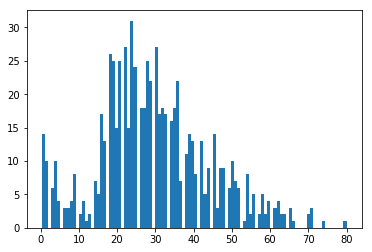

In [25]:
df_age = df_train.loc[df_train["Age"].isnull() == False, :]
#sel_non_nan

plt.hist(df_age["Age"], bins=100)
plt.show()

Three groups:
below 15 (1),
15 to 50 (2) and
above 50 (3)

In [26]:
age_list = []
for a in df_age["Age"]:
    if a <= 15:
        age_list.append("AgeU15")
    elif 15 < a <= 50:
        age_list.append("AgeB1550")
    else:
        age_list.append("AgeO50")
        
df_age["cat_age"] = age_list

C:\Users\Laszlo Kuehl\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


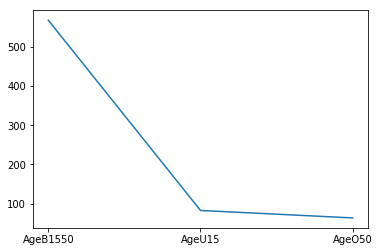

In [27]:
plt.plot(df_age["cat_age"].value_counts())
plt.show()

In [28]:
surv_rate_age = {}

for g in df_age["cat_age"].unique():
    selection = df_age.loc[df_age["cat_age"] == g, :]
    freq = sum(selection["Survived"])/len(selection["Survived"])
    surv_rate_age.update({g : freq})

surv_rate_age

{'AgeB1550': 0.3862433862433862,
 'AgeO50': 0.34375,
 'AgeU15': 0.5903614457831325}

In [29]:
ind_cat_pclass("cat_age", df_age, df_train)

{'AgeB1550': 0.02309885238014453,
 'AgeO50': 0.5487078233857212,
 'AgeU15': -0.45268367537693677}

In [30]:
ind_cat_sex("cat_age", df_age, df_train)

{'AgeB1550': -0.0032417223234791903,
 'AgeO50': -0.023030339826529245,
 'AgeU15': -0.19461287478927602}

Summary: Children have a higher survival rate than all older people and this is not explained by them being located in passenger class 1 more frequently (-0.45 indecated that "Pclass" would underestimate their suvival rate by 45%).
People above the age of 50 seem to have a rather average survial rate eventhough they are located in better passenger classes( 0.55 indicates that "Pclass" as a sole predictor overstimates the survival rate of a person above the age of 50 by 55 %)

In [31]:
binarization("cat_age", df_age, df_train)
df_train = df_train.drop(["Age", "AgeB1550", "AgeO50"], axis = 1)
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Cabin,Embarked,3,1,2,u10,FareOver80,AgeU15
0,1,0,3,"Braund, Mr. Owen Harris",male,1,0,A/5 21171,NaN,S,1,0,0,1,0,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,PC 17599,C85,C,0,1,0,0,0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",female,0,0,STON/O2. 3101282,NaN,S,1,0,0,1,0,0.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,1,0,113803,C123,S,0,1,0,0,0,0.0
4,5,0,3,"Allen, Mr. William Henry",male,0,0,373450,NaN,S,1,0,0,1,0,0.0


### SibSp and Parch

In [32]:
df_train["Groupsize"] = df_train["SibSp"] + df_train["Parch"]

In [33]:
x = sorted(list(df_train["Groupsize"].value_counts().index))
y = pd.DataFrame(df_train["Groupsize"].value_counts())

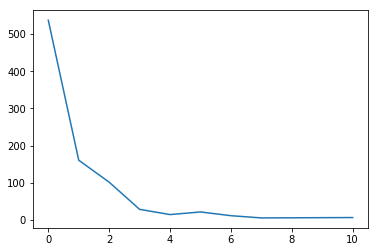

In [34]:
plt.plot(y.loc[x, :])
plt.show()

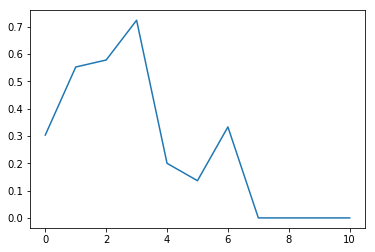

In [35]:
surv_rate_group = {}

for g in df_train["Groupsize"].unique():
    selection = df_train.loc[df_train["Groupsize"] == g, :]
    freq = sum(selection["Survived"])/len(selection["Survived"])
    surv_rate_group.update({g : freq})

surv_rate_group = dict(sorted(surv_rate_group.items()))
plt.plot(list(surv_rate_group.keys()),list(surv_rate_group.values()))
plt.show()

Smaller groups seem to have a higher rate of survival

In [36]:
ind = ind_cat_pclass("Groupsize", df_train, df_train)
dict(sorted(ind.items()))

C:\Users\Laszlo Kuehl\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide


{0: 0.20447239829190433,
 1: -0.1689345507672363,
 2: -0.30237697452032286,
 3: -0.3935519396682654,
 4: 0.5468118839049207,
 5: 1.3705025127550883,
 6: -0.2729124236252546,
 7: inf,
 10: inf}

In [37]:
ind2 = ind_cat_sex("Groupsize", df_train, df_train)
dict(sorted(ind2.items()))

C:\Users\Laszlo Kuehl\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


{0: 0.04992676760887349,
 1: -0.11756710546373117,
 2: -0.21403382496209844,
 3: -0.23867582997830605,
 4: 2.157061011822627,
 5: 1.8603399235374418,
 6: 0.672984578701608,
 7: inf,
 10: inf}

In [38]:
large_group = []

for e in df_train["Groupsize"]:
    if e >= 4:
        large_group.append(1)
    else:
        large_group.append(0)

    
df_train["Large_Group"] = large_group

In [39]:
df_train = df_train.drop(["Groupsize", "Parch", "SibSp"], axis = 1)

## Preprocessing (non-numeric features)

### Embarked

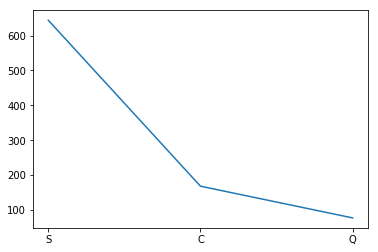

In [40]:
plt.plot(df_train["Embarked"].value_counts())
plt.show()

In [41]:
df_train["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [42]:
df_train["Embarked"].unique()

array(['S', 'C', 'Q', nan], dtype=object)

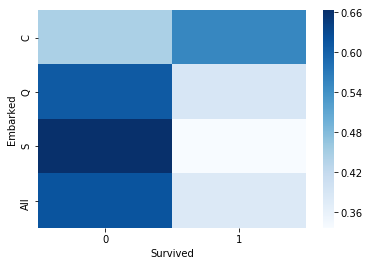

In [43]:
df_embarked = sel_non_nan("Embarked", df_train)

crossES = pd.crosstab(df_embarked["Embarked"], df_embarked["Survived"], margins= True, normalize = "index")

sns.heatmap(crossES, cmap = "Blues")
plt.show()

In [44]:
ind_cat_pclass("Embarked", df_embarked, df_train)

{'S': 0.12009406779075693, 'C': -0.1661022722900669, 'Q': -0.3290720215625762}

In [45]:
ind_cat_sex("Embarked", df_embarked, df_train)

{'S': 0.07807488554296449, 'C': -0.22456920818200887, 'Q': 0.1486203254994165}

It can be seen that there exists a dependency between embarkmentin Southampton and Cherburgh and the Passenger classes of the respective passengers.
This means that from a causal point of view, passengers embarking in C had a bigger chance of survival than those embarking in S simply because they were more frequently in passenger class 1. (0.0 would mean that the suvival of a person at a given point can be describe 100% by the passenger class, which would render the inofrmation of embarkment useless)


What is curious on the other hand is that passengers embarking in Q have a "survival rate" close to the avarage of 38.38 %, EVENTHOUGH they are allocated to more than 90% in p-class 3 (avarage survival rate). The deviation of roughly -32.9 % means that up to one third of the better survival of passengers embarking at Q cannit be explained only by the passenger class.

This disparity could be explained by the fact, that some passengers of p-class 3 were located in the very back of the ship and some in the front, which hit the iceberg first. OR it is purely randomness caused by the separation of the underlying data into train and test sets. Only 77/891 = 8.64% of the observed embarkments happened in Queenstown.   

In [46]:
binarization("Embarked", df_embarked, df_train)
df_train = df_train.drop(["Embarked", "S", "C"], axis = 1)

In [47]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Ticket,Cabin,3,1,2,u10,FareOver80,AgeU15,Large_Group,Q
0,1,0,3,"Braund, Mr. Owen Harris",male,A/5 21171,NaN,1,0,0,1,0,0.0,0,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,0,1,0,0,0,0.0,0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NaN,1,0,0,1,0,0.0,0,0.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,0,1,0,0,0,0.0,0,0.0
4,5,0,3,"Allen, Mr. William Henry",male,373450,NaN,1,0,0,1,0,0.0,0,0.0


### Cabin

In [48]:
p_room = df_train["Cabin"].value_counts()

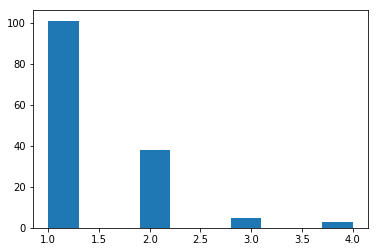

In [49]:
plt.hist(p_room)
plt.show()

In [50]:
df_train["Cabin"].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [51]:
df_cabin = sel_non_nan("Cabin", df_train)

In [52]:
# "Cabin Letter/Deck" - column 
cletter_col = []
for e in  df_cabin["Cabin"]:
    letter = e[0]
    cletter_col.append(letter)

df_cabin["CLetter"] = cletter_col

In [53]:
# "Passengers per room" - column 
p_room_dict = dict(zip(list(p_room.index), list(p_room)))
                  
p_room_col = []
for e in df_cabin["Cabin"]:
    ppr = p_room_dict.get(e)
    p_room_col.append(ppr)
    
df_cabin["PperRoom"] = p_room_col

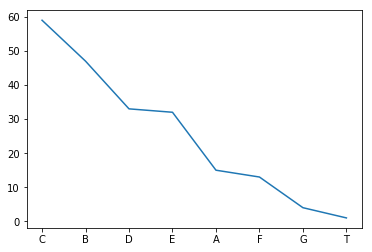

In [54]:
plt.plot(df_cabin["CLetter"].value_counts())
plt.show()

In [55]:
ind_cat_pclass("CLetter", df_cabin, df_train)

C:\Users\Laszlo Kuehl\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide


{'C': 0.06137566137566153,
 'E': -0.2350361389607678,
 'G': -0.5152749490835031,
 'D': -0.1939774557165861,
 'A': 0.3492063492063493,
 'B': -0.15449735449735447,
 'F': -0.375697334632073,
 'T': inf}

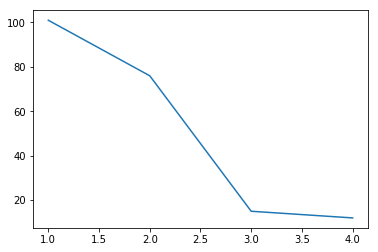

In [56]:
plt.plot(df_cabin["PperRoom"].value_counts())
plt.show()

In [57]:
ind_cat_pclass("PperRoom", df_cabin, df_train)

{1: 0.06430891535449734,
 2: -0.2205224347488116,
 4: -0.24918910764124613,
 3: -0.31247255160298615}

Considering an immense lack of data for this column can be dropped. Most of the disparities arising above are too small to be relevant for the entire dataset (overfitting)

In [58]:
df_train = df_train.drop(["Cabin"], axis = 1)
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Ticket,3,1,2,u10,FareOver80,AgeU15,Large_Group,Q
0,1,0,3,"Braund, Mr. Owen Harris",male,A/5 21171,1,0,0,1,0,0.0,0,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,0,1,0,0,0,0.0,0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,1,0,0,1,0,0.0,0,0.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,0,1,0,0,0,0.0,0,0.0
4,5,0,3,"Allen, Mr. William Henry",male,373450,1,0,0,1,0,0.0,0,0.0


### Ticket

In [59]:
df_train["Ticket"].unique()

array(['A/5 21171', 'PC 17599', 'STON/O2. 3101282', '113803', '373450',
       '330877', '17463', '349909', '347742', '237736', 'PP 9549',
       '113783', 'A/5. 2151', '347082', '350406', '248706', '382652',
       '244373', '345763', '2649', '239865', '248698', '330923', '113788',
       '347077', '2631', '19950', '330959', '349216', 'PC 17601',
       'PC 17569', '335677', 'C.A. 24579', 'PC 17604', '113789', '2677',
       'A./5. 2152', '345764', '2651', '7546', '11668', '349253',
       'SC/Paris 2123', '330958', 'S.C./A.4. 23567', '370371', '14311',
       '2662', '349237', '3101295', 'A/4. 39886', 'PC 17572', '2926',
       '113509', '19947', 'C.A. 31026', '2697', 'C.A. 34651', 'CA 2144',
       '2669', '113572', '36973', '347088', 'PC 17605', '2661',
       'C.A. 29395', 'S.P. 3464', '3101281', '315151', 'C.A. 33111',
       'S.O.C. 14879', '2680', '1601', '348123', '349208', '374746',
       '248738', '364516', '345767', '345779', '330932', '113059',
       'SO/C 14885', '31012

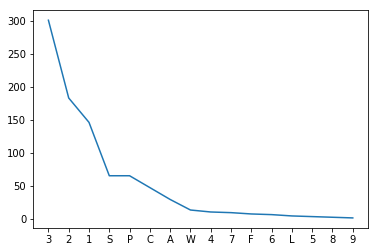

In [60]:
#Letter
letter_col = []
for e in  df_train["Ticket"]:
    letter = e[0]
    letter_col.append(letter)

df_train["TLetter"] = letter_col
plt.plot(df_train["TLetter"].value_counts())
plt.show()

In [61]:
ind_cat_pclass("TLetter", df_train, df_train)

C:\Users\Laszlo Kuehl\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide


{'A': 2.5142566191446027,
 'P': -0.060701963617486476,
 'S': 0.046480015011406195,
 '1': -0.05643141252336925,
 '3': 0.10451635317810415,
 '2': -0.13733441889600584,
 'C': 1.9370406446395094e-05,
 '7': 1.1812627291242364,
 'W': 1.5019524139830964,
 '4': 0.21181262729124217,
 'F': -0.19096935253237834,
 'L': -0.03054989816700615,
 '9': -0.7576374745417516,
 '6': 1.2287093610922533,
 '5': inf,
 '8': inf}

The interpretation here is not very easy. Most of disparities in significant categories (such as 3, 2, 1 or even S) can already be explained by "Pclass".
For applying a machine learning model this feature will therefore be dropped.

In [62]:
df_train = df_train.drop(["Ticket", "TLetter"], axis = 1)

### Sex

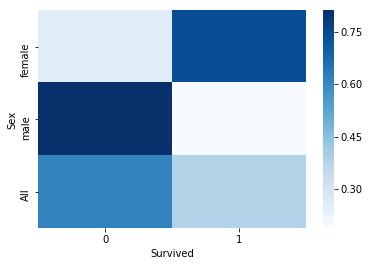

In [63]:
crossSS = pd.crosstab(df_train["Sex"], df_train["Survived"], margins= True, normalize = "index")

#Heatmap
sns.heatmap(crossSS, cmap = "Blues")
plt.show()

In [64]:
ind_cat_pclass("Sex", df_train, df_train)

{'male': 0.9447690691755175, 'female': -0.4419735130477741}

The disparity between male and female passengers regarding rate of survival is quite striking. 
These findings shows that though they died, they died as gentlemen!

Considering that there are no missing values in this feature is also largely indepent from feature "Pclass" and it will be therefore included in our analysis. 

In [65]:
binarization("Sex", df_train, df_train)
df_train = df_train.drop(["Sex", "male"], axis = 1)
df_train.head()

,PassengerId,Survived,Pclass,Name,3,1,2,u10,FareOver80,AgeU15,Large_Group,Q,female
0,1,0,3,"Braund, Mr. Owen Harris",1,0,0,1,0,0.0,0,0.0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,0,0,0.0,0,0.0,1
2,3,1,3,"Heikkinen, Miss. Laina",1,0,0,1,0,0.0,0,0.0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,0,0,0.0,0,0.0,1
4,5,0,3,"Allen, Mr. William Henry",1,0,0,1,0,0.0,0,0.0,0


## Preparing train and test sets

### Training Set

In [66]:
df_train = df_train.drop(["PassengerId", "Name", "Pclass"],  axis=1)
df_train = df_train.fillna(0)
df_train.head()

,Survived,3,1,2,u10,FareOver80,AgeU15,Large_Group,Q,female
0,0,1,0,0,1,0,0.0,0,0.0,0
1,1,0,1,0,0,0,0.0,0,0.0,1
2,1,1,0,0,1,0,0.0,0,0.0,1
3,1,0,1,0,0,0,0.0,0,0.0,1
4,0,1,0,0,1,0,0.0,0,0.0,0


### Test Set

In [67]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [68]:
count_nan(df_test)

There are 0 missing values in PassengerId
There are 0 missing values in Pclass
There are 0 missing values in Name
There are 0 missing values in Sex
There are 86 missing values in Age
There are 0 missing values in SibSp
There are 0 missing values in Parch
There are 0 missing values in Ticket
There are 1 missing values in Fare
There are 327 missing values in Cabin
There are 0 missing values in Embarked


In [69]:
#Fare
df_fare = sel_non_nan("Fare", df_test)

fare_list= []
for e in df_fare["Fare"]:
    if e <= 10:
        fare_list.append("u10")
    elif 10 < e <= 20:
        fare_list.append("b1020")
    elif 20 < e <= 30:
        fare_list.append("b2030")
    elif 30 < e <= 40:
        fare_list.append("b3040")
    elif 40 < e <= 60:
        fare_list.append("b4060")
    elif 60 < e <= 80:
        fare_list.append("b6080")
    elif 80 < e <= 100:
        fare_list.append("b80100")
    elif 100 < e <= 200:
        fare_list.append("b100200")
    elif 200 < e <= 300:
        fare_list.append("b200300")
    else:
        fare_list.append("g300")
        
df_fare["cat_fare"] = fare_list
binarization("cat_fare", df_fare, df_test)
df_test["FareOver80"] = df_test["b100200"] + df_test['b80100'] + df_test['g300'] + df_test['b200300']


df_test = df_test.drop(["Fare","b6080", 'b4060', 'b2030', 'b1020', 'b3040','b200300','b100200', 'b80100', 'g300'], axis = 1)

In [70]:
#Pclass
binarization("Pclass", df_test, df_test,)
df_test = df_test.drop("Pclass", axis = 1)

In [71]:
#Age
df_age_test = sel_non_nan("Age", df_test)

age_list = []
for a in df_age_test["Age"]:
    if a <= 15:
        age_list.append("AgeU15")
    elif 15 < a <= 50:
        age_list.append("AgeB1550")
    else:
        age_list.append("AgeO50")
        
df_age_test["cat_age"] = age_list
binarization("cat_age", df_age_test, df_test)


df_test = df_test.drop(["Age", "AgeB1550", "AgeO50"], axis = 1)

In [72]:
#Embarked
binarization("Embarked", df_test, df_test)
df_test = df_test.drop(["Embarked", "S", "C"], axis = 1)

In [73]:
#Cabin
df_test = df_test.drop("Cabin", axis = 1)

In [74]:
#Ticket
df_test = df_test.drop(["Ticket"], axis = 1)

In [75]:
#SibSP and Parch
df_test["Groupsize"] = df_test["SibSp"] + df_test["Parch"]

large_group = []

for e in df_test["Groupsize"]:
    if e >= 4:
        large_group.append(1)
    else:
        large_group.append(0)

    
df_test["Large_Group"] = large_group


df_test = df_test.drop(["Groupsize", "Parch", "SibSp"], axis = 1)

In [76]:
#Sex
binarization("Sex", df_test, df_test)
df_test = df_test.drop(["Sex", "male"], axis = 1)

In [77]:
#Filling NaNs
df_test = df_test.fillna(0)

#### Dropping

In [78]:
#For submitting a prediction:
ID_col = list(df_test["PassengerId"])
ID_col = np.array(ID_col)

#last drop
df_test = df_test.drop(["PassengerId", "Name"],  axis=1)

In [79]:
#Fooled by randomness --> try and reapeat lead to dropping these insignificant features
df_train = df_train.drop(["u10", "FareOver80", "Q"], axis = 1)
df_test = df_test.drop(["u10", "FareOver80", "Q"], axis = 1)

In [80]:
df_train.head()

,Survived,3,1,2,AgeU15,Large_Group,female
0,0,1,0,0,0.0,0,0
1,1,0,1,0,0.0,0,1
2,1,1,0,0,0.0,0,1
3,1,0,1,0,0.0,0,1
4,0,1,0,0,0.0,0,0


In [81]:
df_test.head()

,3,2,1,AgeU15,Large_Group,female
0,1,0,0,0.0,0,0
1,1,0,0,0.0,0,1
2,0,1,0,0.0,0,0
3,1,0,0,0.0,0,0
4,1,0,0,0.0,0,1


Train-Test-Split

In [82]:
X_train, y_train, X_test = df_train.iloc[:,1:], df_train.iloc[:,0], df_test

# Machine Learning

## Import

In [83]:
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold

#regressions
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

#Gaussian
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier

#KNeighbors Classifier
from sklearn import neighbors

#decsion tree
from sklearn.tree import DecisionTreeClassifier

#Support Vector Machine
from sklearn.svm import SVC

#Ensembles
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

C:\Users\Laszlo Kuehl\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Laszlo Kuehl\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Applying models (with cross validation)

In [84]:
k_fold = KFold(891, n_folds=9, shuffle = True, random_state = 0) 

### LogistcRegression

In [86]:
log = LogisticRegression()
scores = cross_val_score(log, X_train,y_train, cv = k_fold, scoring ="accuracy")
print(round(np.mean(scores)*100, 2))
print(round(np.std(scores)*100, 2))

81.14
1.96


### GaussianProcessClassifier

In [87]:
gpc = GaussianProcessClassifier()
scores = cross_val_score(gpc, X_train,y_train, cv = k_fold, scoring ="accuracy")
print(round(np.mean(scores)*100, 2))
print(round(np.std(scores)*100, 2))

83.05
2.46


### GaussianNB

In [88]:
gnb = GaussianNB()
scores = cross_val_score(gnb, X_train,y_train, cv = k_fold, scoring ="accuracy")
print(round(np.mean(scores)*100, 2))
print(round(np.std(scores)*100, 2))

78.68
4.53


### KNeighborsClassifier

In [89]:
knn = neighbors.KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn, X_train,y_train, cv = k_fold, scoring ="accuracy")
print(round(np.mean(scores)*100, 2))
print(round(np.std(scores)*100, 2))

80.36
3.87


### DecisionTreeClassifier

In [90]:
dtc = DecisionTreeClassifier()
scores = cross_val_score(dtc, X_train,y_train, cv = k_fold, scoring ="accuracy")
print(round(np.mean(scores)*100, 2))
print(round(np.std(scores)*100, 2))

82.83
2.43


### SVC

In [91]:
svm = SVC(kernel = "poly", degree = 2)
scores = cross_val_score(svm, X_train,y_train, cv = k_fold, scoring ="accuracy")
print(round(np.mean(scores)*100, 2))
print(round(np.std(scores)*100, 2))

80.02
2.93


### RandomForestClassifier

In [92]:
rfc = RandomForestClassifier()
scores = cross_val_score(rfc, X_train,y_train, cv = k_fold, scoring ="accuracy")
print(round(np.mean(scores)*100, 2))
print(round(np.std(scores)*100, 2))

83.05
2.46


### Voting Classifier

In [102]:
evc = VotingClassifier(estimators= [("dtc",dtc), ("gpc", gpc), ("log", log)], voting = "hard")
evc.fit(X_train,y_train)
evc.score(X_train,y_train)
print(round(np.mean(scores)*100, 2))
print(round(np.std(scores)*100, 2))

83.05
2.46


C:\Users\Laszlo Kuehl\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Submissions

### Ensemble 1

In [100]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
y_pred1 = rfc.predict(X_test)
Sub1 = pd.DataFrame({"PassengerId" : ID_col,"Survived" : y_pred1})
Sub1.to_csv("Sub1.csv", index = False)
Sub1.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


### Ensemble 2

In [103]:
evc = VotingClassifier(estimators= [("dtc",dtc), ("gpc", gpc), ("log", log)], voting = "hard")
evc.fit(X_train,y_train)
y_pred2 = evc.predict(X_test)
Sub2 = pd.DataFrame({"PassengerId" : ID_col,"Survived"  : y_pred2})
Sub2.to_csv("Sub2.csv", index = False)
Sub2.head()

C:\Users\Laszlo Kuehl\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [104]:
Sub2.loc[Sub2["Survived"] != Sub1["Survived"], :]

,PassengerId,Survived
64,956,0


#### Public Score on Kaggle: 0.78947 (VotingClassifier and RandomForestClassifier )